In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [63]:
print(json.dumps({f"{run}" : [[lumi, lumi] for lumi in lumis] for run, lumis in out["lumi"].items()}))

{"357542": [[75, 75], [85, 85]]}


In [53]:
class Processor(processor.ProcessorABC):
    def __init__(self, wp_btag=0.2):
        self._wp_btag = wp_btag
        
    @property
    def accumulator(self):
        return {
            "sumw": defaultdict(float),
            "templates": (
                            Hist.new.StrCategory(
                                [], name="dataset", label="Dataset", growth=True
                            ).Reg(
                                30, 40, 220, name="msoftdrop", label=r"msoftdrop"
                            ).Reg(
                                30, 150, 1000, name="pt", label=r"$p_T$"
                            ).Reg(
                                30, 0, 10, name="nPV", label=r"Number of PV"
                            ).Double()
                        ),
        }
           
        
    def process(self, events):
        
        output = self.accumulator
        dataset = events.metadata['dataset']
        
        isRealData = not hasattr(events, "genWeight")
        
        selection = PackedSelection()
        
        if not isRealData:
            output['sumw'][dataset] += ak.sum(events.genWeight)
            
        if len(events) == 0:
            return output
        
        pvs = events.ScoutingPrimaryVertex
        pvs = pvs[
            (pvs.isValidVtx)
            & (pvs.ndof > 4)
            & (np.abs(pvs["z"]) < 24)
        ]
        
        fatjets = events.ScoutingFatJet
        fatjets = fatjets[
            (fatjets.neHEF < 0.9)
            & (fatjets.neEmEF < 0.9)
            & (fatjets.muEmEF < 0.8)
            & (fatjets.chHEF > 0.01)
            & (fatjets.nCh > 0)
            & (fatjets.chEmEF < 0.8)
        ]
        fatjets = fatjets[ak.argsort(fatjets.pt, axis=1)]
        
        # trigger
        selection.add("trigger", events.L1["SingleJet180"])
        
        # large radius jet
        selection.add("fatjetpt", ak.firsts(fatjets).pt > 200)
            
        regions = {
            #'all': ['trigger', 'fatjetpt'],
            'noselection' : []
        }
        
        def normalize(val, cut):
            if cut is None:
                ar = ak.to_numpy(ak.fill_none(val, np.nan))
                return ar
            else:
                ar = ak.to_numpy(ak.fill_none(val[cut], np.nan))
                return ar
            
        def fill(region):
            selections = regions[region]
            cut = selection.all(*selections)
            
            output['templates'].fill(
                dataset=dataset,
                msoftdrop=normalize(ak.firsts(fatjets).msoftdrop, cut),
                pt=normalize(ak.firsts(fatjets).pt, cut),
                nPV=normalize(ak.num(pvs), cut)
            )
            
        for region in regions:
            fill(region)
            
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [54]:
fileset = {
    "Run2022D" : [
        "root://eosuser.cern.ch//eos/user/a/adlintul/ScoutingPFRun3/Run2022D/230206_163934/0000/scoutingnano_1.root"
    ],
}

p = Processor()

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema = ScoutingNanoAODSchema,
    #maxchunks = 10,
)

out = futures_run(
    fileset,
    treename="Events",
    processor_instance=p
)

Output()

In [2]:
out = util.load("outfiles/Run3Summer22/pv_Run2022D.coffea")

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f8ce626d520>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f8ce626d910>, text=[])

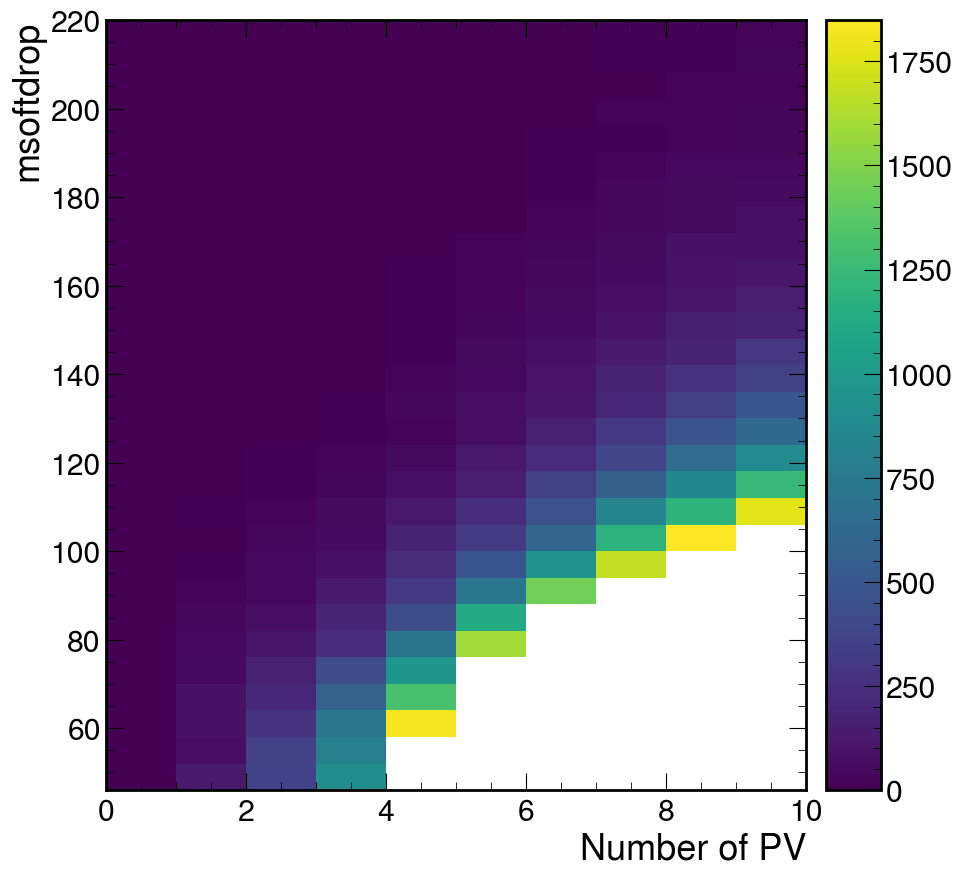

In [26]:
mplhep.hist2dplot(
    out["templates"].project("nPV", "msoftdrop")[::hist.rebin(3),50j:],
    cmin=0,
    cmax=2000
)

(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f8cf470b8b0>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8cf470bd60>, errorbar=None, legend_artist=None)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8cf471b070>, errorbar=None, legend_artist=None)])

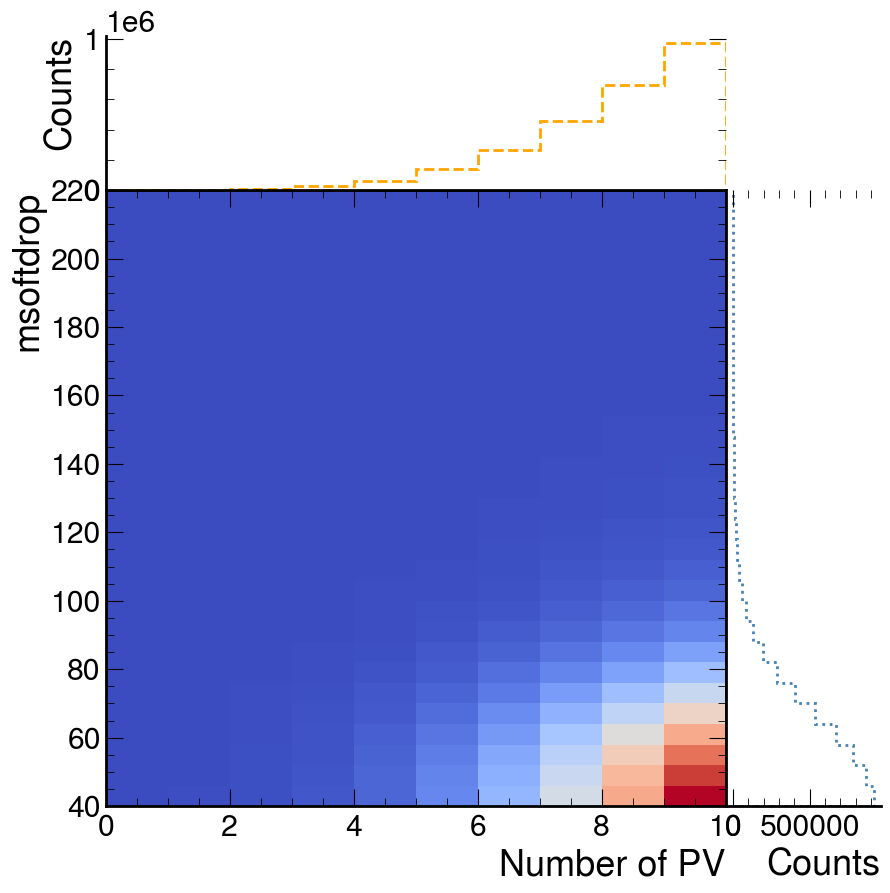

In [14]:
out["templates"].project("nPV", "msoftdrop")[::hist.rebin(3),:].plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

(ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f8cf4578d60>, cbar=None, text=[]),
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8cf45e6280>, errorbar=None, legend_artist=None)],
 [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8cf4509160>, errorbar=None, legend_artist=None)])

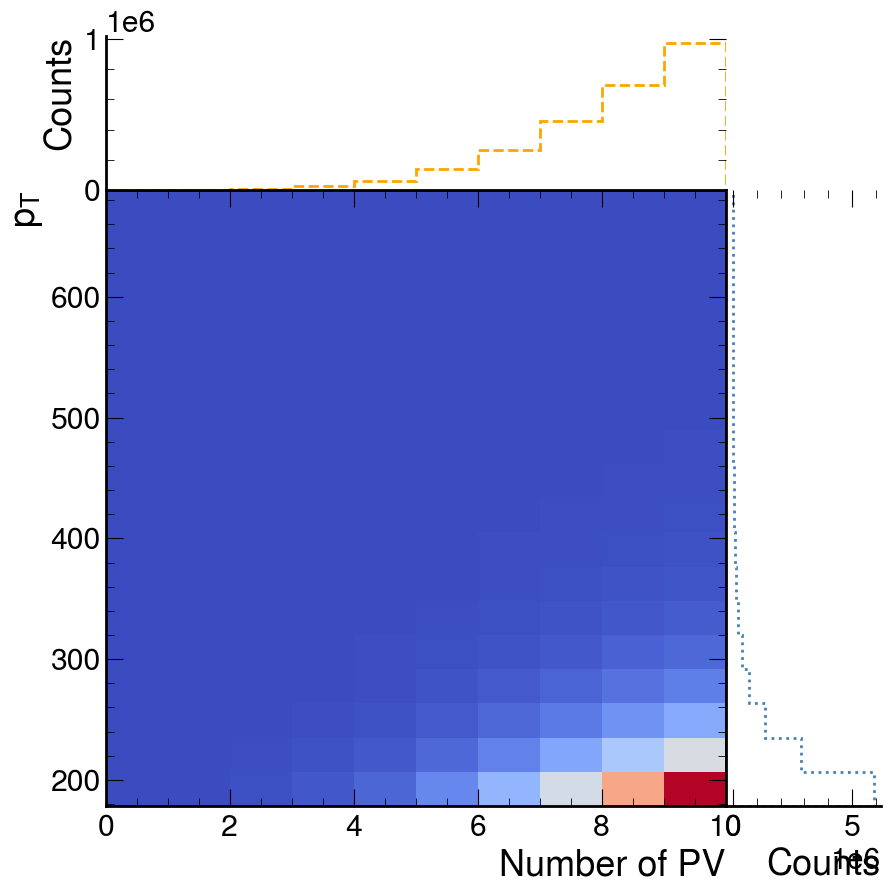

In [15]:
out["templates"].project("nPV","pt")[::hist.rebin(3),200j:700j].plot2d_full(
    main_cmap="coolwarm",
    top_ls="--",
    top_color="orange",
    top_lw=2,
    side_ls=":",
    side_lw=2,
    side_color="steelblue",
)

In [16]:
hist.plot2d(
    out["templates"].project("nPV", "msoftdrop")[::hist.rebin(3),:],
    xaxis = "nPV",
    patch_opts={'vmax': 0.4, 'vmin': 0.15, 'cmap': 'jet'}
)

AttributeError: module hist has no attribute plot2d